In [1]:
import pandas as pd
import numpy as np
import requests as requests
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode


## HYDRO Generation Estimation

In [64]:
#First of all, we try to create a model for eolic energy with 2014 data that we can extrapolate afterwards
generation_2014 = pd.read_csv('./Data/Generation/Generation_2014.csv')
#We use info or head fucntions to take a quick view on data
generation_2014.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       6314 non-null   float64
 1   percentage  6314 non-null   float64
 2   datetime    6314 non-null   object 
 3   Type        6314 non-null   object 
dtypes: float64(2), object(2)
memory usage: 197.4+ KB


In [65]:
#In order to have a 'cleaner' datetime and to order it by datetime:

generation_2014['FECHA'] = generation_2014['datetime'].str[:10]
generation_2014['FECHA'] = pd.to_datetime(generation_2014['FECHA'])
generation_2014 = generation_2014.sort_values(by = 'FECHA', ignore_index = True)
generation_2014.head()

,value,percentage,datetime,Type,FECHA
0,73065.0520,0.110822,2014-01-01T00:00:00.000+01:00,Hidráulica,2014-01-01
1,4616.7525,0.007003,2014-01-01T00:00:00.000+01:00,Residuos no renovables,2014-01-01
2,146015.5030,0.221470,2014-01-01T00:00:00.000+01:00,Nuclear,2014-01-01
3,54043.0770,0.081970,2014-01-01T00:00:00.000+01:00,Cogeneración,2014-01-01
4,25240.6550,0.038284,2014-01-01T00:00:00.000+01:00,Carbón,2014-01-01


In [68]:
#At this point we are only interested in hydroelectric (hidroeolica production is minimal), therefore:
hydro_generation_2014 = generation_2014[(generation_2014['Type'] == 'Hidráulica')]
hydro_generation_2014.groupby('Type').describe()

value                                                     \
            count           mean           std        min        25%   
Type                                                                   
Hidráulica  365.0  107347.904734  52115.768864  28827.347  67735.832   

                                            percentage                      \
                  50%        75%        max      count      mean       std   
Type                                                                         
Hidráulica  89171.545  142063.74  250695.19      365.0  0.145835  0.067168   

                                                              
                 min       25%       50%       75%       max  
Type                                                          
Hidráulica  0.046103  0.094134  0.124389  0.184855  0.347909

# HYDROELECTRIC

It is expected to be not such dependant of the weather as eolic or solar power, but drought periods can affect the production.
In order to see how predictable it is the production depending on the level of the dams, the analysis includes data of the dams's level as well as weather data.
'Embalses _2014_2023' file includes information regarding the level of the dams in Spain from 2014 to 2023 in hm³. It is a public file and can be downloade from https://www.miteco.gob.es/es/agua/temas/evaluacion-de-los-recursos-hidricos/boletin-hidrologico/

In [2]:
# Dam data it is in xlsx format. We are going to process it and adapt it to pandas.

embalses = pd.read_excel('./Data/Hidro/T_Embalses_2014_2023.xlsx')
embalses.head()

,AMBITO_NOMBRE,EMBALSE_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG
0,Miño - Sil,Albarellos,2014-01-07,"91,00","58,00",1
1,Miño - Sil,Albarellos,2014-01-14,"91,00","53,00",1
2,Miño - Sil,Albarellos,2014-01-21,"91,00","51,00",1
3,Miño - Sil,Albarellos,2014-01-28,"91,00","43,00",1
4,Miño - Sil,Albarellos,2014-02-04,"91,00","43,00",1


In [3]:
embalses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175147 entries, 0 to 175146
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   AMBITO_NOMBRE   175147 non-null  object        
 1   EMBALSE_NOMBRE  175147 non-null  object        
 2   FECHA           175147 non-null  datetime64[ns]
 3   AGUA_TOTAL      175147 non-null  object        
 4   AGUA_ACTUAL     175147 non-null  object        
 5   ELECTRICO_FLAG  175147 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 8.0+ MB


In [4]:
str(embalses['AGUA_TOTAL'])
embalses['AGUA_TOTAL'] = embalses['AGUA_TOTAL'].str.replace(',' , '.')
embalses['AGUA_TOTAL'] = embalses['AGUA_TOTAL'].apply(pd.to_numeric)

In [5]:
embalses.head()

,AMBITO_NOMBRE,EMBALSE_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG
0,Miño - Sil,Albarellos,2014-01-07,91.0,"58,00",1
1,Miño - Sil,Albarellos,2014-01-14,91.0,"53,00",1
2,Miño - Sil,Albarellos,2014-01-21,91.0,"51,00",1
3,Miño - Sil,Albarellos,2014-01-28,91.0,"43,00",1
4,Miño - Sil,Albarellos,2014-02-04,91.0,"43,00",1


In [6]:
#In order to see the main dams for electricty production in Spain:

top_20 = pd.DataFrame(embalses.groupby('EMBALSE_NOMBRE')['AGUA_TOTAL'].mean().sort_values(ascending = False).head(20))
top_20

,AGUA_TOTAL
EMBALSE_NOMBRE,
La Serena,3219.000000
Alcántara,3160.000000
Almendra,2649.000000
Buendía,1669.210309
Mequinenza,1534.000000
Cijara,1505.000000
Valdecañas,1446.000000
Ricobayo,1145.000000
Alarcón,1118.000000


In [7]:
#The column 'ELECTRICO_FLAG' marks those dams which are used to obtain electricty. Those are the ones that we need. Therefore:

embalses_electricity = embalses.loc[embalses['ELECTRICO_FLAG'] == 1]
embalses_electricity.head()

,AMBITO_NOMBRE,EMBALSE_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG
0,Miño - Sil,Albarellos,2014-01-07,91.0,"58,00",1
1,Miño - Sil,Albarellos,2014-01-14,91.0,"53,00",1
2,Miño - Sil,Albarellos,2014-01-21,91.0,"51,00",1
3,Miño - Sil,Albarellos,2014-01-28,91.0,"43,00",1
4,Miño - Sil,Albarellos,2014-02-04,91.0,"43,00",1


In [8]:
#embalses_electricity_daily = pd.DataFrame(embalses_electricty.resample('d', on = 'FECHA'))
#embalses_electricity_daily.head(50)

In [9]:
embalses['YEAR'] = pd.DatetimeIndex(embalses['FECHA']).year.to_numpy()
embalses.groupby('YEAR').nunique()

#As we see below, Date information is given by week, not in a daily basis

,AMBITO_NOMBRE,EMBALSE_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG
YEAR,,,,,,
2014,16,356,52,172,1036,2
2015,16,356,52,172,946,2
2016,16,357,52,175,917,2
2017,16,362,52,178,800,2
2018,16,360,52,174,877,2
2019,16,360,53,177,822,2
2020,16,368,52,176,839,2
2021,16,371,52,178,767,2
2022,16,372,52,191,682,2


In [10]:
#As a first approach we are going to consider the same values for a whole week. To do so:
#date_year = pd.DataFrame(pd.date_range(start = '1/1/2014', end = '12/31/2022'), columns = ['FECHA'])
#date_year['year'] = pd.DatetimeIndex(date_year['FECHA']).year.to_numpy()
#date_year.groupby('year').nunique()
#embalses_daily = date_year.merge(embalses, on = 'FECHA', how = 'left')
#embalses_daily.isnull().sum(axis = 0)


In [11]:
embalses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175147 entries, 0 to 175146
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   AMBITO_NOMBRE   175147 non-null  object        
 1   EMBALSE_NOMBRE  175147 non-null  object        
 2   FECHA           175147 non-null  datetime64[ns]
 3   AGUA_TOTAL      175147 non-null  float64       
 4   AGUA_ACTUAL     175147 non-null  object        
 5   ELECTRICO_FLAG  175147 non-null  int64         
 6   YEAR            175147 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 9.4+ MB


In [12]:
#We have pased from a df of 175K rows to a df of 45k
embalses_electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44753 entries, 0 to 166416
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AMBITO_NOMBRE   44753 non-null  object        
 1   EMBALSE_NOMBRE  44753 non-null  object        
 2   FECHA           44753 non-null  datetime64[ns]
 3   AGUA_TOTAL      44753 non-null  float64       
 4   AGUA_ACTUAL     44753 non-null  object        
 5   ELECTRICO_FLAG  44753 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.4+ MB


In [13]:
embalses_electricity.groupby('EMBALSE_NOMBRE').count() #94 dams with eletrcicity production

,AMBITO_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG
EMBALSE_NOMBRE,,,,,
"Agavanzal, Nª Sª de",485,485,485,485,485
Albarellos,485,485,485,485,485
Alcántara,485,485,485,485,485
Aldeadávila,485,485,485,485,485
Almendra,485,485,485,485,485
...,...,...,...,...,...
Valdecañas,485,485,485,485,485
Valparaíso,485,485,485,485,485
Velle,485,485,485,485,485


As we can see, there is no information related to the CCAA or province, which would make it difficult to analyze data and to match it 
with the other variables and data we have.

In [14]:
#The information is provided by 'Cuenca Hidrográfica' instead. 
embalses_electricity['AMBITO_NOMBRE'].unique()

array(['Miño - Sil', 'Duero', 'Tajo', 'Guadalquivir', 'Segura', 'Júcar',
       'Ebro', 'Galicia Costa', 'Cantábrico Occidental'], dtype=object)

In [15]:
#Which are the dams left?
embalses_to_consider = embalses_electricity['EMBALSE_NOMBRE'].unique()
len(embalses_to_consider)

94

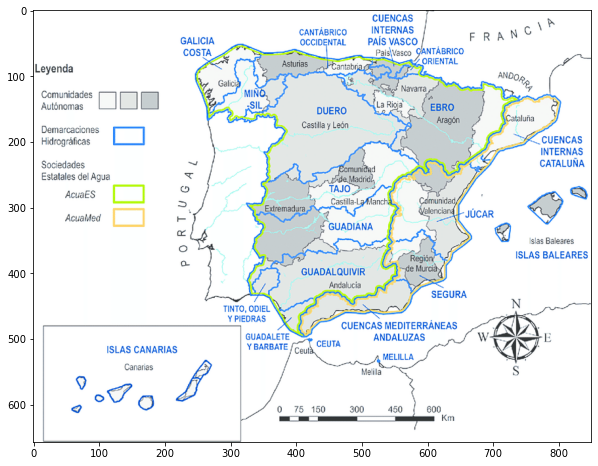

In [16]:
#We are going to need to match it to our politic strcuture somehow in order to analyze the data.
#Below it is a picture that help to understand how it could match.
from matplotlib import image as img
spain_image = img.imread('./Data/Hidro/hidropolitic_spain.png')
fig, ax = plt.subplots(figsize = (10,8))
plt.imshow(spain_image)

In order to be able to match the information between the status of the dams and the provicences, a dams' inventory can be found also in https://www.miteco.gob.es/es/agua/temas/seguridad-de-presas-y-embalses/inventario-presas-y-embalses/.


In [17]:
presas = pd.read_csv('./Data/Hidro/Presas.csv', encoding = 'latin-1', sep = ';')
presas.rename({'Presa':'EMBALSE_NOMBRE'}, axis = 1, inplace = True)
presas.head()

,EMBALSE_NOMBRE,Demarcación,Cauce,Fase,Titular,Provincia
0,ABENOJAR,GUADIANA,ARROYO DE LA VIRGEN,Explotación,AYUNTAMIENTO DE ABENOJAR,Ciudad Real
1,ABRILONGO,NaN,RIO ABRILONGO,Explotación,PORTUGAL,NaN
2,ACEBO,TAJO,RIVERA DE ACEBO,Explotación,"JUNTA DE EXTREMADURA, CONSEJERÍA DE FOMENTO, V...",Cáceres
3,ACECA,TAJO,SIN NOMBRE,Explotación,IBERDROLA GENERACION S.A.,Toledo
4,ACEHUCHE,TAJO,ARROYO DE LA GARGANTA,Explotación,"JUNTA DE EXTREMADURA, CONSEJERÍA DE FOMENTO, V...",Cáceres


In [18]:
presas_names = list(presas['EMBALSE_NOMBRE'].unique())

for item in embalses_to_consider:
    if item not in presas_names:
        print(f'{item} no se encuentra')
    else:
        pass

Albarellos no se encuentra
Bao no se encuentra
Belesar no se encuentra
Campañana, La no se encuentra
Castrelo no se encuentra
Cenza no se encuentra
Chandrexa no se encuentra
Conchas, Las no se encuentra
Edrada-Mao no se encuentra
Frieira no se encuentra
Guístolas no se encuentra
Matalavilla no se encuentra
Montefurado no se encuentra
Peares, Os no se encuentra
Peñarrubia no se encuentra
Pías (San Agustín) no se encuentra
Portas, Las no se encuentra
Prada no se encuentra
Rozas, Las no se encuentra
Salas no se encuentra
San Martiño no se encuentra
San Pedro no se encuentra
San Sebastián no se encuentra
San. Estevo no se encuentra
Santa Eulalia no se encuentra
Sequeiros no se encuentra
Velle no se encuentra
Agavanzal, Nª Sª de no se encuentra
Aldeadávila no se encuentra
Almendra no se encuentra
Burgomillodo no se encuentra
Castro no se encuentra
Cernadilla no se encuentra
Puente Porto no se encuentra
Rábanos no se encuentra
Ricobayo no se encuentra
Saucelle no se encuentra
Valparaíso no s

In [19]:
#Several names are not recognised in 'presas' mainly due to the  accent mark. In order to remove it we are going to use unidecode
embalses_names_encoded = []
for item in embalses_to_consider:
    encoded = unidecode(item)
    embalses_names_encoded.append(encoded)
    
presas_names_encoded = []
for item in presas_names:
    encoded = unidecode(item)
    presas_names_encoded.append(encoded)

not_found = []
for item in embalses_names_encoded:
    if item not in presas_names_encoded:
        not_found.append(item)
    else:
        pass
len(not_found)

94

In [20]:
#Let's joint it with 'embalses_electricty':
#Embalses names have to be upper if we want to matche them:
embalses_electricity['EMBALSE_NOMBRE'] = embalses_electricity['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)
presas['EMBALSE_NOMBRE'] = presas['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)

embalses_complete = embalses_electricity.merge(presas, on = 'EMBALSE_NOMBRE', how= 'inner')
embalses_complete = pd.DataFrame(embalses_complete.groupby('EMBALSE_NOMBRE').count())


/tmp/ipykernel_3022/4150194402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embalses_electricity['EMBALSE_NOMBRE'] = embalses_electricity['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)


In [21]:
embalses_complete.head()

,AMBITO_NOMBRE,FECHA,AGUA_TOTAL,AGUA_ACTUAL,ELECTRICO_FLAG,Demarcación,Cauce,Fase,Titular,Provincia
EMBALSE_NOMBRE,,,,,,,,,,
ALBARELLOS,485,485,485,485,485,485,485,485,485,485
ALCANTARA,485,485,485,485,485,485,485,485,485,485
ALDEADAVILA,485,485,485,485,485,485,485,485,485,485
ALMENDRA,485,485,485,485,485,485,485,485,485,485
ALMOGUERA,485,485,485,485,485,485,485,485,485,485


In [22]:
#Let's compile all this proccessing into a function

def embalses_elect_year (year):

    #Firstly, we read the 'embalses' data and select only the year we want and to process 'Embalse Nombre' in order to match it with 'presas' file.
    #We only want the dams with the electricty flag marked
    
    embalses_elect = pd.read_excel('./Data/Hidro/T_Embalses_2014_2023.xlsx')
    embalses_elect = embalses_elect.loc[embalses_elect['ELECTRICO_FLAG'] == 1]
    embalses_elect['year'] = pd.DatetimeIndex(embalses_elect['FECHA']).year

    #In order to transform water KPIs into numeric
    str(embalses_elect['AGUA_TOTAL'])
    embalses_elect['AGUA_TOTAL'] = embalses_elect['AGUA_TOTAL'].str.replace(',' , '.')
    embalses_elect['AGUA_TOTAL'] = embalses_elect['AGUA_TOTAL'].apply(pd.to_numeric)
    str(embalses_elect['AGUA_ACTUAL'])
    embalses_elect['AGUA_ACTUAL'] = embalses_elect['AGUA_ACTUAL'].str.replace(',' , '.')
    embalses_elect['AGUA_ACTUAL'] = embalses_elect['AGUA_ACTUAL'].apply(pd.to_numeric)

    #In order to have the information of the year that we want and to get the name of the dam in the way to match it with 'presas' file

    embalses_elect = embalses_elect.query('year == @year')
    embalses_elect['EMBALSE_NOMBRE'] = embalses_elect['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)

    #Now, we have to preprocess 'presas' data

    presas = pd.read_csv('./Data/Hidro/Presas.csv', encoding = 'latin-1', sep = ';')
    presas.rename({'Presa':'EMBALSE_NOMBRE'}, axis = 1, inplace = True)
    presas['EMBALSE_NOMBRE'] = presas['EMBALSE_NOMBRE'].apply(unidecode)

    #At last, the joint. It will be some dams not matched but are not relevant for our study:

    embalses_capacity = embalses_elect.merge(presas, on = 'EMBALSE_NOMBRE', how= 'inner')
    
    return embalses_capacity


In [23]:
embalses_capacity_2014 = embalses_elect_year(2014)

/tmp/ipykernel_3022/3832148451.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embalses_elect['EMBALSE_NOMBRE'] = embalses_elect['EMBALSE_NOMBRE'].apply(str.upper).apply(unidecode)


In [24]:
embalses_capacity_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4316 entries, 0 to 4315
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AMBITO_NOMBRE   4316 non-null   object        
 1   EMBALSE_NOMBRE  4316 non-null   object        
 2   FECHA           4316 non-null   datetime64[ns]
 3   AGUA_TOTAL      4316 non-null   float64       
 4   AGUA_ACTUAL     4316 non-null   float64       
 5   ELECTRICO_FLAG  4316 non-null   int64         
 6   year            4316 non-null   int64         
 7   Demarcación     4264 non-null   object        
 8   Cauce           4160 non-null   object        
 9   Fase            4316 non-null   object        
 10  Titular         4316 non-null   object        
 11  Provincia       4316 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 438.3+ KB


In [25]:
embalses_capacity_2014['FECHA'].nunique()

52

In [26]:
embalses_electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44753 entries, 0 to 166416
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   AMBITO_NOMBRE   44753 non-null  object        
 1   EMBALSE_NOMBRE  44753 non-null  object        
 2   FECHA           44753 non-null  datetime64[ns]
 3   AGUA_TOTAL      44753 non-null  float64       
 4   AGUA_ACTUAL     44753 non-null  object        
 5   ELECTRICO_FLAG  44753 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 2.4+ MB


In [27]:

embalses_capacity_2014.groupby('EMBALSE_NOMBRE')['AGUA_TOTAL'].mean().sort_values(ascending = False).head(20)

EMBALSE_NOMBRE
ALCANTARA                   3160.0
ALMENDRA                    2649.0
MEQUINENZA                  1534.0
VALDECANAS                  1446.0
RICOBAYO                    1145.0
CANELLES                     679.0
BELESAR                      655.0
PORTAS, LAS                  536.0
PORTODEMOUROS                297.0
SALIME                       266.0
CEDILLO                      260.0
CERNADILLA                   255.0
BAO                          238.0
RIBARROJA                    210.0
TORREJON (TAJO - TIETAR)     188.0
PEARES, OS                   182.0
SAUCELLE                     181.0
VALPARAISO                   169.0
ESCALES                      152.0
ULLIVARRI                    146.0
Name: AGUA_TOTAL, dtype: float64

Most of the relevant dams related to hydro generation are already included after applying the function, therefore it should be enough to work with this structure to get valid information. This data, however, is set in a weekly basis. We are going to need to make a fullfill in order to align it with our daily weather data

In [28]:
embalses_electricity.groupby('EMBALSE_NOMBRE')['AGUA_TOTAL'].mean().sort_values(ascending = False).head(20)

EMBALSE_NOMBRE
ALCANTARA                   3160.000000
ALMENDRA                    2649.000000
MEQUINENZA                  1534.000000
VALDECANAS                  1446.000000
RICOBAYO                    1145.000000
CANELLES                     679.000000
BELESAR                      655.000000
PORTAS, LAS                  536.000000
PORTODEMOUROS                297.000000
SALIME                       264.325773
CEDILLO                      260.000000
CERNADILLA                   255.000000
BAO                          238.000000
TREMP O TALARN               218.154639
SAN. ESTEVO                  213.000000
RIBARROJA                    210.000000
TORREJON (TAJO - TIETAR)     188.000000
PEARES, OS                   182.000000
SAUCELLE                     181.000000
VALPARAISO                   169.000000
Name: AGUA_TOTAL, dtype: float64

## JOIN WEATHER, PRODUCTION AND RESERVOIR DATA

Let's create the dataframe that we are going to use for analysis and to build the model.

In [29]:
#We have to extract weather data for the same period we are analysing, 2014 in this case:

weather_2014 = pd.read_csv('./Data/Weather/Weather2014.csv')
weather_2014.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fecha        92888 non-null  object 
 1   indicativo   92888 non-null  object 
 2   nombre       92888 non-null  object 
 3   provincia    92888 non-null  object 
 4   altitud      92888 non-null  int64  
 5   tmed         89480 non-null  object 
 6   prec         88915 non-null  object 
 7   tmin         89484 non-null  object 
 8   horatmin     87598 non-null  object 
 9   tmax         89506 non-null  object 
 10  horatmax     87800 non-null  object 
 11  dir          83078 non-null  float64
 12  velmedia     84451 non-null  object 
 13  racha        83081 non-null  object 
 14  horaracha    83071 non-null  object 
 15  sol          49713 non-null  object 
 16  presMax      67974 non-null  object 
 17  horaPresMax  67970 non-null  object 
 18  presMin      67973 non-null  object 
 19  hora

In [30]:
#In order to replace 'Ip' values in 'prec':

weather_2014.loc[weather_2014['prec'] == 'Ip', 'prec'] = 0

#As we can see below there are not any more 'Ip', so we can proceed with the transformation of 'prec'
prec = weather_2014['prec'].str.contains('Ip')
precacum = weather_2014['prec'].str.contains('Acum')
prec.value_counts()
    

False    87343
Name: prec, dtype: int64

In [31]:
#Let's work with just some of the variables we believe are important:

weather_2014_hydro = weather_2014[['fecha', 'nombre', 'provincia','prec','tmed']]
weather_2014_hydro.dropna().info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 86458 entries, 0 to 92887
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fecha      86458 non-null  object
 1   nombre     86458 non-null  object
 2   provincia  86458 non-null  object
 3   prec       86458 non-null  object
 4   tmed       86458 non-null  object
dtypes: object(5)
memory usage: 4.0+ MB


In [32]:
#We have the information in a daily basis here:

weather_2014_hydro['fecha'].nunique()

365

In [33]:
def transform_columns(columns, x):
    for column in columns:
        x[column] = x[column].str.replace(',', '.')
        x[column] = x[column].apply(pd.to_numeric)

In [34]:
#In order to have in float64 values the information regarding for tmed & prec:
cols = ['prec','tmed']
transform_columns(cols, weather_2014_hydro)
weather_2014_hydro.info()

/tmp/ipykernel_3022/3778751115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[column] = x[column].str.replace(',', '.')
/tmp/ipykernel_3022/3778751115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[column] = x[column].apply(pd.to_numeric)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   fecha      92888 non-null  object 
 1   nombre     92888 non-null  object 
 2   provincia  92888 non-null  object 
 3   prec       87343 non-null  float64
 4   tmed       89480 non-null  float64
dtypes: float64(2), object(3)
memory usage: 3.5+ MB


In [35]:
weather_2014_hydro.rename({'fecha': 'FECHA'}, axis = 1, inplace = True)

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [36]:
weather_2014_hydro['FECHA'] =weather_2014_hydro['FECHA'].apply(to_datetime)

/tmp/ipykernel_3022/4214896902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_2014_hydro['FECHA'] =weather_2014_hydro['FECHA'].apply(to_datetime)


In [37]:
weather_2014_hydro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92888 entries, 0 to 92887
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      92888 non-null  datetime64[ns]
 1   nombre     92888 non-null  object        
 2   provincia  92888 non-null  object        
 3   prec       87343 non-null  float64       
 4   tmed       89480 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 3.5+ MB


In [38]:
weather_2014_hydro.head()

,FECHA,nombre,provincia,prec,tmed
0,2014-01-01,DON BENITO,BADAJOZ,0.0,11.0
1,2014-01-01,PUEBLA DE DON RODRIGO,CIUDAD REAL,0.6,8.0
2,2014-01-01,TENERIFE NORTE AEROPUERTO,STA. CRUZ DE TENERIFE,0.0,12.1
3,2014-01-01,ANTEQUERA,MALAGA,0.0,11.4
4,2014-01-01,TALARN,LLEIDA,4.6,2.6


In [39]:
#We calculate now the mean for the main variables that we are going to use in our calculations for each day. In this first naive approach we won't use province information
hydro_pivot_table = weather_2014_hydro.groupby(['FECHA', 'provincia'], as_index=False)[['prec','tmed']].mean()
hydro_pivot_table = hydro_pivot_table.groupby('FECHA', as_index = False)[['prec','tmed']].mean()
hydro_pivot_table

,FECHA,prec,tmed
0,2014-01-01,4.415481,9.505942
1,2014-01-02,5.318309,11.448437
2,2014-01-03,5.284833,12.142549
3,2014-01-04,6.170478,9.433197
4,2014-01-05,2.017804,8.636018
...,...,...,...
360,2014-12-27,4.343178,7.816110
361,2014-12-28,1.414835,7.107250
362,2014-12-29,0.108665,4.303821
363,2014-12-30,0.021047,4.419849


In [40]:
#For now, we will use also for embalses the information not considering province:

embalses_pivot_table = embalses_capacity_2014.groupby(['FECHA', 'Provincia'], as_index = False)[['AGUA_TOTAL', 'AGUA_ACTUAL']].mean()
embalses_pivot_table = embalses_pivot_table.groupby('FECHA', as_index = False)[['AGUA_TOTAL', 'AGUA_ACTUAL']].mean()
embalses_pivot_table.head()

,FECHA,AGUA_TOTAL,AGUA_ACTUAL
0,2014-01-07,201.849405,154.578646
1,2014-01-14,201.849405,164.754539
2,2014-01-21,201.849405,167.082292
3,2014-01-28,201.849405,168.000744
4,2014-02-04,201.849405,175.963021


In [43]:
#Besides that, we need to transform data into daily basis:
print(embalses_pivot_table['FECHA'].max())
print(embalses_pivot_table['FECHA'].min())

2014-12-30 00:00:00
2014-01-07 00:00:00


In [46]:
#We create an empty df with the daily basis we need to merge with
daily_df = pd.DataFrame(pd.date_range(start= hydro_pivot_table['FECHA'].min(), end = hydro_pivot_table['FECHA'].max()), columns = ['FECHA'])
daily_df

,FECHA
0,2014-01-01
1,2014-01-02
2,2014-01-03
3,2014-01-04
4,2014-01-05
...,...
360,2014-12-27
361,2014-12-28
362,2014-12-29
363,2014-12-30


In [61]:
#Now we merge it with our water reservoir data
embalses_pivot_table_daily = pd.merge(daily_df, embalses_pivot_table, how = 'left', on = 'FECHA')

#In order to fulfill NA values

embalses_pivot_table_daily['AGUA_TOTAL'] = embalses_pivot_table_daily['AGUA_TOTAL'].interpolate(method = 'linear', limit_direction = 'both').round(decimals = 2)

#Interpolate help us to do it in a more progressive way with Agua Actual

embalses_pivot_table_daily['AGUA_ACTUAL'] = embalses_pivot_table_daily['AGUA_ACTUAL'].interpolate(method = 'linear',limit_direction = 'both').round(decimals = 2)

In [62]:
embalses_pivot_table_daily.tail(50)

,FECHA,AGUA_TOTAL,AGUA_ACTUAL
315,2014-11-12,201.85,145.62
316,2014-11-13,201.85,146.34
317,2014-11-14,201.85,147.07
318,2014-11-15,201.85,147.79
319,2014-11-16,201.85,148.52
320,2014-11-17,201.85,149.24
321,2014-11-18,201.85,149.97
322,2014-11-19,201.85,150.08
323,2014-11-20,201.85,150.20
324,2014-11-21,201.85,150.32


In [60]:
embalses_pivot_table_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        365 non-null    datetime64[ns]
 1   AGUA_TOTAL   365 non-null    float64       
 2   AGUA_ACTUAL  365 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.4 KB


In [72]:
total_hydro_2014 = pd.merge(embalses_pivot_table_daily, hydro_pivot_table, how = 'left', on = 'FECHA')
total_hydro_2014 = pd.merge(total_hydro_2014, hydro_generation_2014, how = 'left', on = 'FECHA')
total_hydro_2014.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   FECHA        365 non-null    datetime64[ns]
 1   AGUA_TOTAL   365 non-null    float64       
 2   AGUA_ACTUAL  365 non-null    float64       
 3   prec         365 non-null    float64       
 4   tmed         365 non-null    float64       
 5   value        365 non-null    float64       
 6   percentage   365 non-null    float64       
 7   datetime     365 non-null    object        
 8   Type         365 non-null    object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 28.5+ KB


## DATA VISUALIZATION

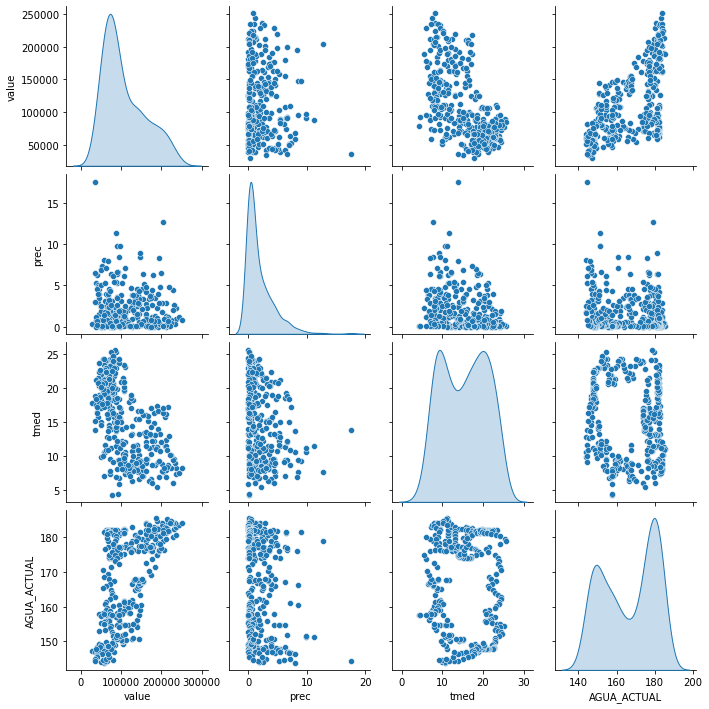

In [73]:
#Let's take a look at the correlations:
sns.pairplot(total_hydro_2014[['value','prec', 'tmed', 'AGUA_ACTUAL']],diag_kind='kde')

It seems that there is a correlation between generation (value) and 'agua actual', but also with 'tmed', which makes sense and could mean colineality. Is hard to see a lineal relation with prec (rain)

<AxesSubplot:xlabel='value', ylabel='Count'>

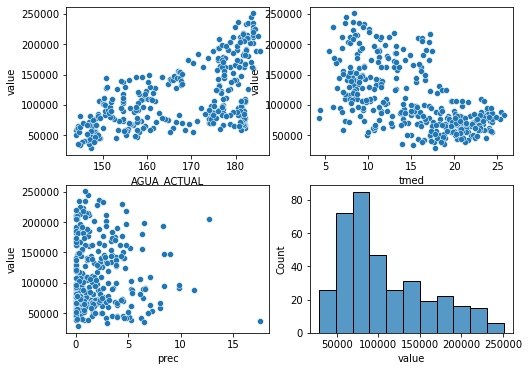

In [78]:
fig, axes = plt.subplots(2,2, figsize = (8,6))
sns.scatterplot(ax = axes[0,0], data = total_hydro_2014 , x = 'AGUA_ACTUAL', y = 'value')
sns.scatterplot(ax = axes[0,1], data = total_hydro_2014 , x = 'tmed', y = 'value')
sns.scatterplot(ax = axes[1,0], data = total_hydro_2014 , x = 'prec', y = 'value')
sns.histplot(ax = axes[1,1], data = total_hydro_2014['value'])

<AxesSubplot:xlabel='FECHA', ylabel='value'>

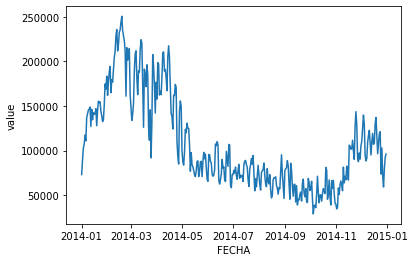

In [81]:
sns.lineplot(data = total_hydro_2014 , x = 'FECHA', y = 'value')

Higher generation values are in spring. It is hardly to understand then why it is apparently a lower correlation with the rain.


## HYDRO ML MODEL

In [127]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [82]:
#We are going to create the model based on linear regression first
#Transform dataframe objects to numpy is needed to be able to reshape the data afterwards

X_hydro = total_hydro_2014[['AGUA_ACTUAL', 'tmed', 'prec']].to_numpy()
y_hydro = total_hydro_2014['value'].to_numpy()

In [99]:
def lr_model (X,y):

    #Estimator would be LR from sklearn

    reg = LinearRegression()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)
    y = y.reshape(-1,1)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
    print(f'Model intercept is {reg.intercept_.round(2)}')
    print(f'Model coefficient is {reg.coef_.round(2)}')
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [100]:
lr_model(X_hydro, y_hydro)

(365, 3)
(365, 1)
Model intercept is [-140573.08]
Model coefficient is [[ 1998.52 -5348.71 -1455.81]]
Model MAE is 22060.84
Model MSE is 742265711.02
Model r2 is 0.695
Model RMSE is 27244.55
CV mean is -5.032 and std is 6.606


array([[111085.56],
       [ 99381.38],
       [ 95717.51],
       [108919.71],
       [119229.09],
       [109298.13],
       [107861.58],
       [109826.32],
       [119322.21],
       [126552.31],
       [129985.01],
       [129458.08],
       [137494.91],
       [138303.84],
       [132396.4 ],
       [140654.78],
       [143487.95],
       [138324.95],
       [152585.18],
       [155209.51],
       [146344.86],
       [145387.94],
       [150860.87],
       [141515.56],
       [130712.17],
       [133500.83],
       [143467.9 ],
       [150675.13],
       [156445.72],
       [161523.29],
       [150620.5 ],
       [158428.02],
       [172648.78],
       [176388.48],
       [161961.01],
       [158209.64],
       [143800.66],
       [161833.33],
       [161249.96],
       [157363.48],
       [176455.75],
       [180854.98],
       [172792.18],
       [153355.08],
       [145849.52],
       [169060.89],
       [184335.35],
       [184300.44],
       [181448.96],
       [178572.84],


In [104]:
#As the results are not promising, let's try to scale data

scaler = StandardScaler()
X_hydro_est = scaler.fit_transform(X_hydro)
X_hydro

array([[1.54580000e+02, 9.50594170e+00, 4.41548086e+00],
       [1.54580000e+02, 1.14484371e+01, 5.31830891e+00],
       [1.54580000e+02, 1.21425488e+01, 5.28483288e+00],
       ...,
       [1.57670000e+02, 4.30382090e+00, 1.08664530e-01],
       [1.57600000e+02, 4.41984862e+00, 2.10470085e-02],
       [1.57600000e+02, 5.93013126e+00, 5.89743590e-03]])

In [103]:
lr_model(X_hydro_est, y_hydro)

(365, 3)
(365, 1)
Model intercept is [107347.9]
Model coefficient is [[ 27362.63 -29524.98  -3434.44]]
Model MAE is 23101.44
Model MSE is 806249290.06
Model r2 is 0.631
Model RMSE is 28394.53
CV mean is -5.032 and std is 6.606


array([[111085.56],
       [ 99381.38],
       [ 95717.51],
       [108919.71],
       [119229.09],
       [109298.13],
       [107861.58],
       [109826.32],
       [119322.21],
       [126552.31],
       [129985.01],
       [129458.08],
       [137494.91],
       [138303.84],
       [132396.4 ],
       [140654.78],
       [143487.95],
       [138324.95],
       [152585.18],
       [155209.51],
       [146344.86],
       [145387.94],
       [150860.87],
       [141515.56],
       [130712.17],
       [133500.83],
       [143467.9 ],
       [150675.13],
       [156445.72],
       [161523.29],
       [150620.5 ],
       [158428.02],
       [172648.78],
       [176388.48],
       [161961.01],
       [158209.64],
       [143800.66],
       [161833.33],
       [161249.96],
       [157363.48],
       [176455.75],
       [180854.98],
       [172792.18],
       [153355.08],
       [145849.52],
       [169060.89],
       [184335.35],
       [184300.44],
       [181448.96],
       [178572.84],


In [106]:
#still not very good. Let's try by dropping 'prec' as we saw in visualization that it was not highly correlated

X_hydro_two = total_hydro_2014[['AGUA_ACTUAL', 'tmed']].to_numpy()
X_hydro_est_two = scaler.fit_transform(X_hydro_two)

lr_model(X_hydro_est_two, y_hydro)

(365, 2)
(365, 1)
Model intercept is [107347.9]
Model coefficient is [[ 28091.22 -28384.82]]
Model MAE is 24483.77
Model MSE is 920199514.08
Model r2 is 0.675
Model RMSE is 30334.79
CV mean is -5.031 and std is 6.775


array([[113008.65],
       [103020.04],
       [ 99450.81],
       [113382.71],
       [117481.93],
       [107273.66],
       [105265.64],
       [107308.05],
       [115551.35],
       [122457.36],
       [126012.91],
       [128965.29],
       [138200.71],
       [137620.73],
       [134075.36],
       [140073.96],
       [145772.05],
       [146271.88],
       [153595.93],
       [152924.02],
       [151216.25],
       [146123.88],
       [147562.21],
       [142499.56],
       [128994.22],
       [132586.1 ],
       [143756.73],
       [152992.25],
       [157637.53],
       [162015.49],
       [151905.54],
       [158491.97],
       [170109.85],
       [175369.73],
       [170179.29],
       [158133.83],
       [150008.4 ],
       [164818.87],
       [163703.27],
       [172255.62],
       [176973.14],
       [183336.93],
       [172665.6 ],
       [152710.04],
       [150545.76],
       [169869.69],
       [182187.71],
       [182619.95],
       [179493.27],
       [175974.75],


In [111]:
def knn_model (X,y):

    #Estimator would be KN from sklearn

    reg = KNeighborsRegressor()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
 
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [110]:
knn_model(X_hydro_est, y_hydro)

(365, 3)
(365,)
Model MAE is 16368.73
Model MSE is 469901374.51
Model r2 is 0.874
Model RMSE is 21677.21
CV mean is -4.236 and std is 6.987


array([ 85966.36,  92386.44, 101615.74,  99666.17, 121281.24, 120876.22,
       120793.87, 128896.41, 135749.74, 129237.54, 131605.28, 126072.16,
       141196.48, 129068.23, 145642.34, 129068.23, 147481.47, 140209.67,
       155207.23, 150277.98, 129762.17, 152368.94, 126206.04, 151635.32,
       114774.34, 130718.35, 141414.02, 149692.78, 155207.23, 157399.56,
       155481.4 , 161265.33, 165878.22, 181557.81, 147133.09, 156847.15,
       164986.27, 173696.46, 169064.44, 156083.33, 175596.7 , 189813.86,
       210443.37, 166239.64, 171964.93, 210287.55, 233533.2 , 231956.77,
       212977.57, 222921.07, 220227.23, 227813.6 , 231139.99, 212977.57,
       212977.57, 210287.55, 211719.  , 212977.57, 173696.46, 155792.39,
       149452.81, 173696.46, 186325.56, 192252.53, 192252.53, 186844.82,
       173427.7 , 183076.14, 184688.14, 196257.98, 197038.78, 216143.12,
       198492.07, 193584.87, 171121.38, 174115.97, 171121.38, 174115.97,
       174115.97, 162893.39, 154715.13, 198455.72, 

In [128]:
def rforest_model (X,y):

    #Estimator would be RandomForest from sklearn

    reg = RandomForestRegressor()

    # Get the number of the features we are including to reshape accordingly afterwards
    shape = X.shape[1]

    #Reshape in order to have data adjusted

    X = X.reshape(-1,shape)

    print(X.shape)
    print(y.shape)
    
    #Fit in order to train the data
    reg.fit(X,y)

    #We split now the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15)

    #Metrics of the model we want to know

    predictions = reg.predict(X).round(2)
    MAE = np.round(mean_absolute_error(y_test, reg.predict(X_test)),2)
    r2 = np.round(r2_score(y_test, reg.predict(X_test)),3)
    MSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = True),2)
    RMSE = np.round(mean_squared_error(y_test,reg.predict(X_test), squared = False),2)
    cv = cross_val_score(reg, X, y, cv = 5)
    cv_mean = np.round(cv.mean(), 3)
    cv_std = np.round(cv.std(), 3)


    #Outputs
    
 
    print(f'Model MAE is {MAE}')
    print(f'Model MSE is {MSE}')
    print(f'Model r2 is {r2}')
    print(f'Model RMSE is {RMSE}')
    print(f'CV mean is {cv_mean} and std is {cv_std}')

    return predictions

In [130]:
rforest_model(X_hydro_est, y_hydro)

(365, 3)
(365,)
Model MAE is 5548.18
Model MSE is 58325039.13
Model r2 is 0.976
Model RMSE is 7637.08
CV mean is -9.948 and std is 19.211


array([ 87787.2 ,  93807.61,  97427.11, 102825.97, 118782.11, 118404.96,
       132018.17, 135685.33, 131645.11, 139993.15, 140178.62, 122812.35,
       140532.06, 136620.91, 140845.35, 140060.73, 142196.23, 143047.21,
       135516.58, 143731.41, 153978.05, 151931.18, 152502.23, 144617.78,
       138496.33, 135298.89, 138197.93, 149504.81, 171713.99, 171111.71,
       173660.44, 164745.23, 175760.45, 182437.69, 173024.81, 158863.82,
       176270.53, 174598.8 , 178324.01, 180570.75, 198877.25, 215314.3 ,
       221191.32, 205275.81, 196489.  , 215843.2 , 230888.99, 231916.75,
       239674.82, 221042.92, 221910.57, 224974.32, 212590.15, 181688.49,
       205944.25, 196945.44, 211661.89, 215359.46, 176242.2 , 160434.86,
       155838.62, 156843.19, 163451.76, 186913.22, 203134.56, 198973.54,
       175058.05, 177739.84, 192939.44, 191520.8 , 207081.04, 221081.74,
       217406.97, 169561.61, 146410.14, 183400.52, 185458.04, 177707.5 ,
       186364.28, 176266.02, 137634.83, 131204.97, 